In [1]:
import init

from analisys.bkt_analisys import *
from analisys.data_analisys import *
from analisys.graph_analisys import *
from analisys.optmizer_analisys import *


import pandas as pd
import seaborn as sns

import random
import os

from backend.resampler import *
from backend.mt5_tools import *

from statsmodels.tsa.stattools import adfuller
from analisys.graph_analisys import moving_avg

from secrets import token_hex as token


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.orca.config.use_xvfb = True


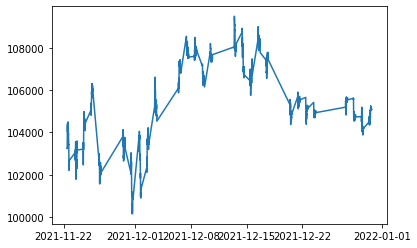

In [2]:
#definindo parametros


start_date = '2021.11.22'
end_date = '2022.01.03'


param = 'roiloss'
csv_l = 'symbols_ibovf.csv'
opt = 'forest'


timeframe = 5 # timeframe = 5 minutos
sample_size = 10 # quantidade de pares sendo negociados simultaneamente 
n_opt = 25 # parametro do optmizer 22
lags = 20 # parametro do 'teste de cointegracao' 025
p_size = 3000 # tamanho da posicao

d_train = 30 # numero de dias sendo 'treinados'.
d_test = 5 # numero de dias sendo 'testados'.

ibov = pd.DataFrame(mt5_singlehistoricaldata('IBOV', 5, start_date, end_date, forex=False, SERVER='tcp://192.168.0.29:10000')).iloc[::-1]
period = [100,250]
stop_n = [20,100]
stop_r = [-300, 0]
s_spread = [1, 5]
l_spread = [-5, -1]
tp_s =[-1, 0]
tp_l =[0, 1]
tp_r =[700, 3000]
c_min=[100, 300]

plt.plot(ibov['close'])

space_param = [(period[0], period[1]),
                (s_spread[0], s_spread[1]),
                (l_spread[0], l_spread[1]),
                (tp_s[0], tp_s[1]),
                (tp_l[0], tp_l[1]),
                (tp_r[0], tp_r[1]),
                (stop_n[0], stop_n[1]),
                (stop_r[0], stop_r[1]),
                (c_min[0], c_min[1])]

In [3]:
def get_days(start_date, end_date, d_train, d_test):

    ibov = mt5_singlehistoricaldata('IBOV', 16408, start_date, end_date, SERVER='tcp://192.168.0.29:10000')
    ibov_date = list(ibov['date'])
    ibov_date.reverse()

    date_iteration = []

    for d in range(len(ibov_date))[:-(d_train+d_test)]:

        train_startdate = ibov_date[d].split(' ')[0]
        train_enddate = ibov_date[d+d_train].split(' ')[0]
        test_startdate = ibov_date[d+d_train].split(' ')[0]
        test_enddate = ibov_date[d+d_test+d_train].split(' ')[0]

        date_iteration.append(tuple([train_startdate, train_enddate,
                                    test_startdate, test_enddate]))

    #real_startdate = date_iteration[0][2]
    #real_enddate = date_iteration[-1][-2]

    return date_iteration, ibov_date

def cointpair_selection(df, dataframe, lags):

    co_list = []
    

    co = h_coint(hist, dataframe, n_lags=lags)
    co = pd.DataFrame(co)
    co = co.sort_values(by=['pvalue'])
    co = co.reset_index(drop=True)

    new_co = pd.DataFrame({'pvalue':pd.Series([]), 'stdx':pd.Series([]), 
                                'stdy':pd.Series([]), 'x':pd.Series([]), 'y':pd.Series([])})


    if(len(co) == 0):
        return new_co

    co_len = [i for i in range(len(co))]
    
    for j in co_len:

        x,y = list(co['x'])[j], list(co['y'])[j]

        if not((x in list(new_co['x'])) or (x in list(new_co['y'])) 
               or (y in list(new_co['x'])) or (y in list(new_co['y']))):
                
            new_co = new_co.append(co.iloc()[j])

        new_co = new_co.reset_index(drop=True)
    


    return co

d = get_days(start_date, end_date, d_train, d_test)
len(d[1])
print(len(d[1]), d[1])
print(d[1][2])

29 ['2021.11.22 00:00', '2021.11.23 00:00', '2021.11.24 00:00', '2021.11.25 00:00', '2021.11.26 00:00', '2021.11.29 00:00', '2021.11.30 00:00', '2021.12.01 00:00', '2021.12.02 00:00', '2021.12.03 00:00', '2021.12.06 00:00', '2021.12.07 00:00', '2021.12.08 00:00', '2021.12.09 00:00', '2021.12.10 00:00', '2021.12.13 00:00', '2021.12.14 00:00', '2021.12.15 00:00', '2021.12.16 00:00', '2021.12.17 00:00', '2021.12.20 00:00', '2021.12.21 00:00', '2021.12.22 00:00', '2021.12.23 00:00', '2021.12.27 00:00', '2021.12.28 00:00', '2021.12.29 00:00', '2021.12.30 00:00', '2022.01.03 00:00']
2021.11.24 00:00


In [4]:
#real_startdate = start_date
#train_enddate = end_date
hist = mt5_historicaldata_s(timeframe, start_date, end_date, csv_list = 'symbols_ibovf.csv', interpol=False, bolsa='IBOV')

#real_startdate = '2021.05.10'
#real_enddate = '2021.05.15'

#hist_test = mt5_historicaldata_s(timeframe, real_startdate, real_enddate, csv_list = 'symbols_ibovf.csv', interpol=False, bolsa='IBOV')


In [5]:
co_hist = cointpair_selection(hist, timeframe, lags)
co_hist

AttributeError: 'dict' object has no attribute 'empty'

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

def score(df_treino, name_x, name_y):

    x = np.array(df_treino[name_x]['close']).reshape(-1, 1)
    y = np.array(df_treino[name_y]['close'])

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    model = Ridge()
    visualizer = ResidualsPlot(model)
    visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
    s_ = (visualizer.score(x_test, y_test))  # Evaluate the model on the test data
    #visualizer.show()                 # Finalize and render the figure

    return s_

def simplebkt(symbol_x,
                symbol_y,
                name_x,
                name_y,
                _period,
                s_spread,
                l_spread,
                tp_s,
                tp_l,
                tp_r,
                stop_n,
                stop_r,
                optimizer='Forest'):

    #fname = '{}x{}x{}{}{}.json'.format(name_x, name_y, datetime.datetime.now().hour, datetime.datetime.now().minute, datetime.datetime.now().second)

    dic = runbkt(symbol_x, symbol_y, name_x, name_y, _period,s_spread, l_spread, tp_s, tp_l, tp_r, stop_n, stop_r, pos_size)
    if(optimizer == 'profit'):
        return dic['profit']
    if(optimizer == 'ppp'):
        return dic['profit_per_position']
    if(optimizer == 'sr'):
        return dic['sucess_ratio']
    if(optimizer == 'pl'):
        return dic['average_profit_loss']
    if(optimizer == 'roi'):
        return dic['roi']*abs(dic['profit'])
    if(optimizer == 'dic'):
        return dic
    

def treino(args):

    _p, shortspread, longspread, takeprofitshort, takeprofitlong, takeprofitreturn, stopnumber, stopreturn = args
    r = simplebkt(df_treino[name_x], df_treino[name_y], name_x, name_y, _p, shortspread, longspread, takeprofitshort, takeprofitlong, takeprofitreturn, stopnumber, stopreturn, optimizer='roi')
    return -r

def results(forest, n):
    columns_value = ['period', 's_spread', 'l_spread', 'tp_short', 'tp_long',                                                              'tp_return', 'n', 'stop']
    
    x_iters = np.array(forest['x_iters'])

    df = pd.DataFrame(data = x_iters, columns=columns_value)
    
    df['profit'] = -forest['func_vals']
    df = df.sort_values(['profit'], ascending=False)
    df_np = np.array(df.drop(columns=['profit']))
    df = df.reset_index().drop(columns='index')

    return df[:n], df_np[:n]

In [ ]:
df_treino = hist
#df_test = 
pos_size = 100
opt_param = 'dic'

In [ ]:
resultados = {'std_train':[], 'profit_train':[], 'profit_test':[], 'residuals':[]}

x_sec = list(co_hist['x'])
y_sec = list(co_hist['y'])


for i in range(len(x_sec)):
    print(i)

    name_x = x_sec[i]
    name_y = y_sec[i]

    forest = forest_minimize(treino, space_param, random_state=1, verbose=0, n_calls = n_opt)

    param = forest['x'] 

    train = simplebkt(df_test[name_x], df_test[name_y], name_x, name_y, param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], optimizer=opt_param)

    test = simplebkt(df_test[name_x], df_test[name_y], name_x, name_y, param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], optimizer=opt_param)

    _profit_train = sum(train['returns'])
    _profit_test = sum(test['returns'])
    _std_train = np.std(train['returns'])

    _score = score(df_treino, name_x, name_y)

    resultados['profit_train'].append(_profit_train)
    resultados['profit_test'].append(_profit_test)
    resultados['residuals'].append(_score)
    resultados['std_train'].append(_std_train)



print(resultados)


    



NameError: name 'co_hist' is not defined

In [ ]:
pd.DataFrame(resultados).to_excel('res.xls')

In [ ]:
res = pd.read_excel('res.xls', index_col=0)
res

In [ ]:
plt.scatter(x=res['profit_test'], y=res['residuals'])


In [ ]:
plt.matshow((res['std_train'], res['residuals']))